In [8]:
#!pip install flickr-api-python

In [6]:
#!pip install folium

In [13]:
#pip install -U flickrapi

In [14]:
import flickrapi
import time
import xml.etree.ElementTree as ET
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import preprocessing
import seaborn as sns
import folium
from folium.plugins import HeatMap

# your API key and secret
api_key = u'f7cf6b31fcc4ff7288d80daa8bdb05a9'
api_secret = u'4b638b8ab9e8dc60'

# creation of a FlickrAPI object
flickr = flickrapi.FlickrAPI(api_key, api_secret)

In [20]:
# create a default dictionary to store information about the photos
# the keys are the attributes of interest and the values the data
photo_information = defaultdict(list)

# we loop through the different pages that contain photos of riyadh taken from 2019 to 2021
i = 1
while True:     
    result = flickr.photos.search(
                    per_page=400, #number of data per page
                    has_geo=1, #Photo that has geo location
                    min_taken_date='2019-1-01', # minimum date - 1 Jan 2019
                    max_taken_date='2021-11-16', # maximum data - 16 Nov 2021
                    bbox='46.3513,24.3771,47.0160,25.0607', # boundary box of riyadh
                    media='photos', #collecting only photos (videos excluded)
                    sort='date-taken-desc', 
                    privacy_filter=1,#collecting only public photos (private photos excluded)
                    safe_search=1, #photos without violence
                    extras='geo,url_n,date_taken,views,license',
                    page=i)
    
    # pause the execution of the program 2 seconds
    time.sleep(2)
    
    # obtain the number of pages (first iteration)
    # this information is contained in the photos tag and it will allows us to determine when to break the loop
    if i == 1:
        pages = int(result[0].attrib['pages'])
        print('Number of pages: {}'.format(pages))
    
    # print the number of the page - iteration of the while loop
    print(i, end=' ')  
    
    # loop through all the photos available in the page
    # store (1) the id, (2) the latitude, (3) the longitude, and (4) the URL of the photo in the dictionary  
    for element in result[0].findall('photo'):
        photo_information['id'].append(element.attrib['id'])
        photo_information['latitude'].append(element.attrib['latitude'])
        photo_information['longitude'].append(element.attrib['longitude'])
        photo_information['url_n'].append(element.attrib['url_n'])

    # if the page correspond to the last page we break the loop  
    if i == pages:
        break
    else:
        i = i + 1

Number of pages: 4
1 2 3 4 

In [19]:
# convert the dictionary into a Pandas dataframe
df_photos = pd.DataFrame(photo_information) 

# visualize the first 5 rows of the dataframe
df_photos.head()

,id,latitude,longitude,url_n
0,51657696705,24.631053,46.714425,https://live.staticflickr.com/65535/5165769670...
1,51655933412,24.631053,46.714425,https://live.staticflickr.com/65535/5165593341...
2,51092166747,24.631267,46.713373,https://live.staticflickr.com/65535/5109216674...
3,51643335541,24.681538,46.623466,https://live.staticflickr.com/65535/5164333554...
4,51643986109,24.682511,46.623191,https://live.staticflickr.com/65535/5164398610...


### Data Cleaning


In [21]:
# get a summary of the data frame
df_photos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         724 non-null    object
 1   latitude   724 non-null    object
 2   longitude  724 non-null    object
 3   url_n      724 non-null    object
dtypes: object(4)
memory usage: 22.8+ KB


In [22]:
# convert the columns latitude and longitud into floats
df_photos['latitude'] = df_photos['latitude'].astype(float)
df_photos['longitude'] = df_photos['longitude'].astype(float)

In [24]:
# number of duplicated photos in the data set
df_photos.duplicated().sum()

33

In [25]:
# eliminate duplicated photos from the data set
df_photos = df_photos.drop_duplicates()

# size of the data set after removing duplicated photos
df_photos.shape

(691, 4)

In [26]:
# remove id and url_n columns from the data set
df_photos.drop(['id', 'url_n'], axis=1, inplace=True)

### DBSCAN algorithm


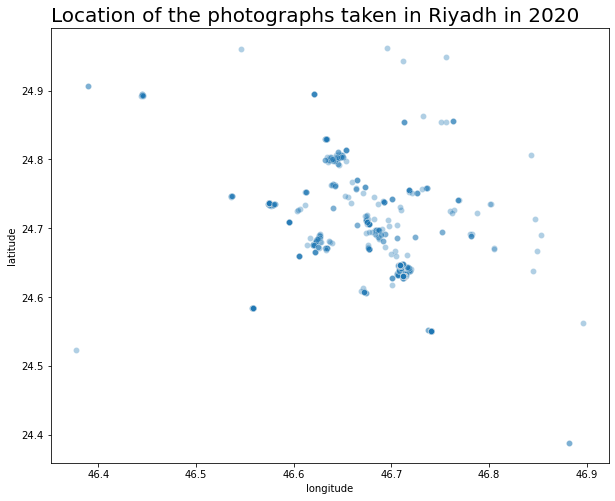

In [28]:
# visualization of the results with a scatter plot
fig = plt.figure(figsize=(10, 8))
plt.title('Location of the photographs taken in Riyadh in 2020', loc='left', fontsize=20)
sns.scatterplot(x=df_photos.longitude, y=df_photos.latitude, alpha=.35);

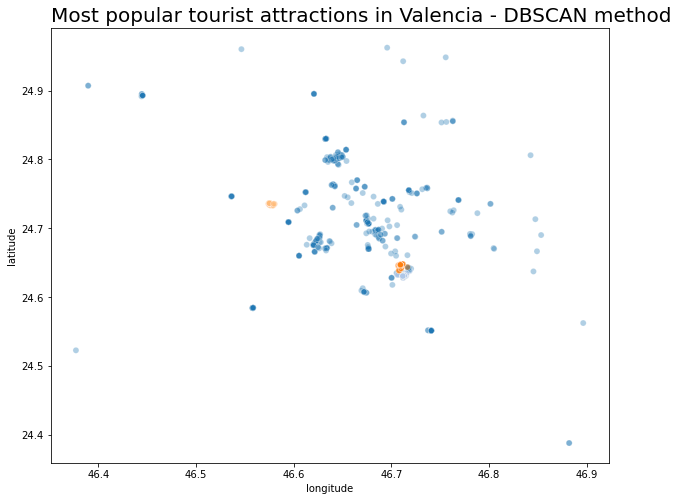

In [29]:
# normalization of the data using the min max method
scaler = preprocessing.MinMaxScaler()

# normalization - fit and transform the data
df_photos_scaled = scaler.fit_transform(df_photos)

# apply the dbscan algorithm to the dataset
tourist_points = cluster.DBSCAN(eps=0.010, min_samples=35).fit(df_photos_scaled)

# labels of the clusters
labels_tourist_points = tourist_points.labels_

# visualization of the results with a scatter plot
fig = plt.figure(figsize=(10, 8))
plt.title('Most popular tourist attractions in Riyadh - DBSCAN method', loc='left', fontsize=20)
sns.scatterplot(x=df_photos.longitude, y=df_photos.latitude, alpha=.35,
                hue=labels_tourist_points, palette="tab20", legend=None);


In [30]:
np.unique(labels_tourist_points)

array([-1,  0,  1,  2])

In [31]:
# exclude the observations with a label equal to -1. 
df_photos_filtered = df_photos[tourist_points.labels_ != -1]

# exclude the labels equal to -1
labels_tourist_points_filtered = labels_tourist_points[labels_tourist_points != -1]


In [32]:
# calculate the center of each cluster
mean_location_clusters = []
for group in np.unique(labels_tourist_points_filtered):
    mean_location_clusters.append(list(df_photos_filtered[labels_tourist_points_filtered==group].mean()))

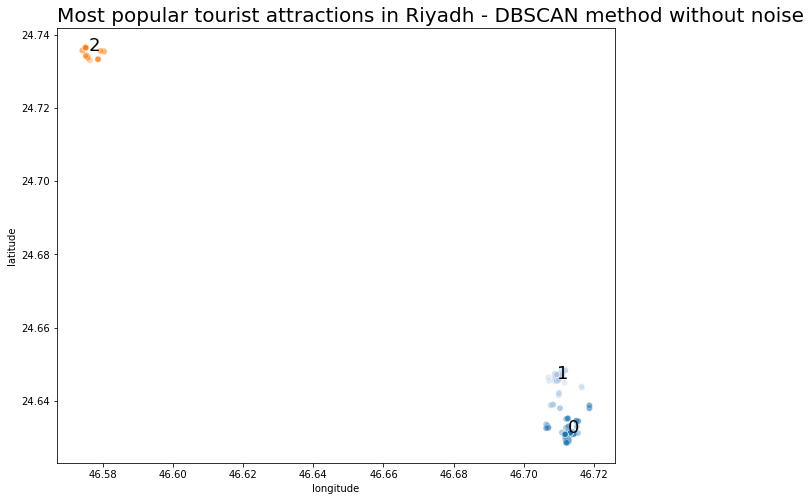

In [47]:
# visualization of the results with a scatter plot
fig = plt.figure(figsize=(10, 8))
plt.title('Most popular tourist attractions in Riyadh - DBSCAN method without noise', loc='left', fontsize=20)
sns.scatterplot(x=df_photos_filtered.longitude, y=df_photos_filtered.latitude, alpha=.35,
                hue=labels_tourist_points_filtered, palette="tab20", legend=None);

# visualize the label associated to each cluster
for index, location in enumerate(mean_location_clusters):
    plt.text(location[1], location[0], str(index), fontsize=18);

In [51]:
# creation of an empty map of Riyadh
riyadh_map = folium.Map(location=[24.3771,46.8787], zoom_start=9)

# plot the locations of the center of the clusters
for index, location in enumerate(mean_location_clusters):
    folium.map.Marker(location=[location[0], location[1]],
                      icon=folium.plugins.BeautifyIcon(border_color='blue',
                                                       text_color='blue',
                                                       number=index,
                                                       icon_shape='marker')).add_to(riyadh_map)

# show the map
riyadh_map

In [49]:
# create an empty map of Riyadh
riyadh_heat_map = folium.Map(location=[24.3771,46.8787], zoom_start=9)

# creation of a Heat map
HeatMap(df_photos, radius=20, blur=20).add_to(riyadh_heat_map)

# show the map
riyadh_heat_map

In [ ]:
# resource: https://towardsdatascience.com/detecting-the-most-popular-tourist-attractions-in-valencia-using-unsupervised-learning-techniques-de0b12fb1ca